This demonstrates all the steps in my candidate selection before conducting visual inspection

In [1]:
import numpy as np
import splat
import wisps.data_analysis as wispd
from wisps.data_analysis import selection_criteria as sel_crt
import shapey
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import wisps

import matplotlib as mpl

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#withnans=wisps.datasets['highsnr']
#wihtoutnans=
alldata=pd.read_hdf(wisps.LIBRARIES+'/master_dataset.hdf',  key='new')

In [3]:
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl') #the simulated spectral data

In [4]:
simulated_data=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten())

In [5]:
simulated_data=wisps.Annotator.reformat_table(simulated_data)

In [6]:
star_ids=alldata[alldata['class_star'] !=0]

In [7]:
stars=wisps.Annotator.reformat_table(star_ids).reset_index(drop=True)

In [8]:
spex=wisps.Annotator.reformat_table(wisps.datasets['spex'])

for k in wisps.INDEX_NAMES:
    fig, ax=plt.subplots()
    
    #plt.hist(spex[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True)
    plt.hist(comb[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True)
    plt.hist(st[k].apply(np.log10).replace((np.inf, -np.inf), np.nan).dropna(), bins=32, histtype='step', normed=True, color='k')
    
    ax.set_title(r'$'+str(k.split(' ')[0])+'$', fontsize=18)
    

In [9]:
cands=pd.read_hdf(wisps.OUTPUT_FILES+'/true_spectra_cands.hdf')

In [10]:
cands=wisps.Annotator.reformat_table(cands)

In [11]:
cands=cands[(cands.spt >=17.) | ((cands.spt >=16))]

In [12]:
dt=stars[(stars.f_test< 0.4) &(stars.snr2>=1.)].reset_index(drop=True)

In [13]:
dt['spt']=(dt['spt']).apply(wisps.make_spt_number).apply(float)

In [14]:
gbhio=sel_crt.save_criteria(conts=dt)

  0%|          | 0/120 [00:00<?, ?it/s]

(2460, 33) (120, 33)


100%|██████████| 120/120 [03:56<00:00,  1.97s/it]


In [15]:
crts=sel_crt.crts_from_file()

In [16]:
contamns=pd.DataFrame([ x.contamination for x in crts.values()])
compls=pd.DataFrame([ x.completeness for x in crts.values()])

In [17]:
compls.min()

L0-L5        0.945559
L5-T0        0.942771
M7-L0        0.953923
T0-T5        0.950413
T5-T9        0.934066
subdwarfs    0.933333
trash        0.946988
Y dwarfs     0.818182
dtype: float64

In [18]:
contamns.index=[x for x in crts.keys()]
compls.index=[x for x in crts.keys()]

In [19]:
1/100

0.01

In [20]:
contamns.style.apply(lambda x: ["background-color: #7FDBFF" 
                          if (i >= 0 and (v < 0.1 
                                          and v > 0. )) 
                          else "" for i, v in enumerate(x)], axis = 1)

,L0-L5,L5-T0,M7-L0,T0-T5,T5-T9,subdwarfs,trash,Y dwarfs
H_2O-1/J-Cont H_2O-2/H_2O-1,0.043633,0.136687,0.076732,0.002602,0.000299,0.141691,0.152909,0.000213
H_2O-1/J-Cont H-cont/H_2O-1,0.148374,0.208840,0.126379,0.093579,0.018810,0.155027,0.165619,0.006341
H_2O-1/J-Cont CH_4/H_2O-1,0.152696,0.214954,0.132905,0.080073,0.001820,0.170752,0.177079,0.002588
H_2O-1/J-Cont H_2O-2/J-Cont,0.053418,0.143288,0.080576,0.003060,0.000356,0.183256,0.165677,0.000199
H_2O-1/J-Cont H-cont/J-Cont,0.116428,0.179097,0.107717,0.077956,0.002505,0.117624,0.143514,0.002690
H_2O-1/J-Cont CH_4/J-Cont,0.120114,0.194070,0.109852,0.096701,0.002477,0.129807,0.152609,0.000327
H_2O-1/J-Cont H-cont/H_2O-2,0.142501,0.188089,0.171972,0.119280,0.025371,0.375979,0.212947,0.007019
H_2O-1/J-Cont CH_4/H_2O-2,0.133815,0.164453,0.170247,0.092299,0.025342,0.366990,0.216432,0.006976
H_2O-1/J-Cont CH_4/H-Cont,0.074632,0.122911,0.095561,0.107776,0.005111,0.170862,0.116119,0.000128
H_2O-1/J-Cont H_2O-1+H_2O-2/J-Cont,0.092371,0.178998,0.117365,0.031989,0.001166,0.278705,0.209196,0.000213


In [21]:
crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

index-index space of H_2O-1/J-Cont H_2O-2/H_2O-1

In [22]:
#

In [23]:
to_use={'H_2O-1/J-Cont H_2O-2/H_2O-1':'L0-L5',
        'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont':'L5-T0' ,
        'H_2O-1/J-Cont H_2O-2/J-Cont':'M7-L0',
        'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont': 'T0-T5',
        'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont': 'T5-T9',
        'H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont': 'Y dwarfs',
        'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

In [24]:
len(to_use)

7

In [25]:
def box_parameters(idx, spt_range):
    bs=idx.shapes
    b=[x for x in bs if x.shape_name==spt_range][0]
    print ('{}  {} m: {} b: {} s:{}, comp : {}, cont: {}'.format(spt_range, idx,  round(b.coeffs[0], 2), round(b.coeffs[1], 2), round(b.scatter, 2), round(idx.completeness[spt_range], 2),  round(idx.contamination[spt_range], 3)))

In [26]:
spex_df=wisps.Annotator.reformat_table(wisps.datasets['spex']).reset_index(drop=True)
manj=wisps.Annotator.reformat_table(wisps.datasets['manjavacas']).reset_index(drop=True)
schn=wisps.Annotator.reformat_table(wisps.datasets['schneider']).reset_index(drop=True)

In [27]:
ydwarfs=(manj[manj['spt'].apply(wisps.make_spt_number)>38].append(schn)).reset_index(drop=True)

In [28]:
spex_df['spt']=np.vstack(spex_df['spt'].values)[:,0]
manj['spt']=np.vstack(manj['spt'].values)[:,0]
schn['spt']=np.vstack(schn['spt'].values)[:,0]

In [29]:
cands_dff=cands.reset_index(drop=True)

In [30]:
import pickle
#save the random forest
output_file=wisps.OUTPUT_FILES+'/best_indices_to_use.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(to_use,file)

In [31]:
#dt

In [32]:
fp={}

In [33]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

In [34]:
stars.grism_id=stars.grism_id.apply(lambda x: x.lower())

In [35]:
cx=cands_dff[cands_dff.grism_id.isin(stars.grism_id)]

In [36]:
cy=stars[stars.grism_id.isin(cx.grism_id)]

In [37]:
idx=crts['H_2O-1/J-Cont H_2O-2/H_2O-1']

In [38]:
cands_dff['spt']=np.vstack(cands_dff['spt'].values)

In [39]:
cands_indices=pd.DataFrame.from_records([x.indices for x in cands_dff.spectra])

In [40]:
for k in wisps.INDEX_NAMES:
    cands_dff[str(k)]=cands_indices[str(k)]

In [41]:
cands_dff=wisps.Annotator.reformat_table(cands_dff)

In [42]:
simulated_data=(simulated_data[simulated_data.snr1>3.]).reset_index(drop=True)

In [43]:
simulated_data['spt']=np.vstack(simulated_data.spt_new.values)[:,0]

In [44]:
def plot_index_box(index_name, box_name, ax):
    
    #get the index and the box
    idx=crts[index_name]
    bx=[x for x in idx.shapes if x.shape_name==box_name][0]
    
    xkey=idx.xkey
    ykey=idx.ykey

    to_use_df=spex_df
    if box_name.lower()=='y dwarfs':
        to_use_df=ydwarfs
    if box_name.lower()=='subdwarfs':
        to_use_df=wisps.Annotator.reformat_table(idx.subdwarfs)
        to_use_df['spt']=17

    ax.scatter(dt[xkey].apply(float).values, dt[ykey].apply(float).values, marker='o', s=10., facecolors='none', edgecolors='#AAAAAA')
    
    
    cands_slctd, cands_bools=bx._select(np.array([cands_dff[xkey].values,cands_dff[ykey].values]))
   
    trash_slctd, trsh_bools=bx._select(np.array([dt[xkey].values, dt[ykey].values]))
    
    simul_slctd, simul_bools=bx._select(np.array([simulated_data[xkey].values, simulated_data[ykey].values]))
    
    
    cands_in_that_class_bool=(cands_dff[ cands_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    spexs_slctd_in_that_class_bool= (to_use_df).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    simulated_in_that_class_bool=(simulated_data[simul_bools]).spt.apply(lambda x: wisps.is_in_that_classification(x, box_name))
    
    if box_name.lower()=='subdwarfs':
         spexs_slctd_in_that_class_bool=np.ones(len(to_use_df), dtype=bool)
    
    
    
    
    cands_in_that_class=np.array([cands_slctd[0][cands_in_that_class_bool], cands_slctd[1][cands_in_that_class_bool]])
    
    simulated_in_that_class= np.array([simul_slctd[0][simulated_in_that_class_bool], simul_slctd[1][simulated_in_that_class_bool]])
    
    spexs_slctd_in_that_class=np.array([to_use_df[xkey][spexs_slctd_in_that_class_bool], to_use_df[ykey][spexs_slctd_in_that_class_bool]])
    

    #ax.scatter( simulated_in_that_class[0],    simulated_in_that_class[1], facecolors='none', s=10, 
    #           edgecolors='#001f3f', label='simulated')
    
    ax.scatter(spexs_slctd_in_that_class[0], spexs_slctd_in_that_class[1], facecolors='#0074D9',  label='SpeX', s=10.)
    
    ax.scatter(cands_dff[xkey], cands_dff[ykey], marker='x', facecolors='#111111', s=10.)
    
    
    ax.scatter( cands_in_that_class[0],    cands_in_that_class[1], marker='x', facecolors='#FF851B', s=10, 
               edgecolors='#2ECC40', label='candidates')
    
    
    
    
    bx.color='None'
    bx.alpha=1.
    bx.linewidth=1
    bx.linestyle='-'
    bx.edgecolor='#111111'
    bx.plot(ax=ax, only_shape=True, highlight=False)
    
    
    ax.set_xlabel(r'$'+str(idx.name.split(' ')[0])+'$', fontsize=15)
    ax.set_ylabel(r'$'+str(idx.name.split(' ')[1])+'$', fontsize=15)
    
    ax.set_title(box_name, fontsize=18)
    
    xbuffer=np.nanstd(to_use_df[[xkey,ykey]])
    
    ax.set_xlim([ bx.xrange[0]-0.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+0.5*abs(np.ptp(bx.xrange))])
    ax.set_ylim([ bx.yrange[0]-0.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+0.5*abs(np.ptp(bx.yrange))])
    
    ax.minorticks_on()
    

    if (trash_slctd.shape[1])==0:
        fprate=0.0
    else:
        fprate=(trash_slctd.shape[1]- cands_slctd.shape[1])/trash_slctd.shape[1]
        if box_name.lower()=='subdwarfs':
                fprate=1.
    
    fp[box_name]=  fprate
    
    plt.tight_layout()
    
    return {str(box_name): bx}
    
    

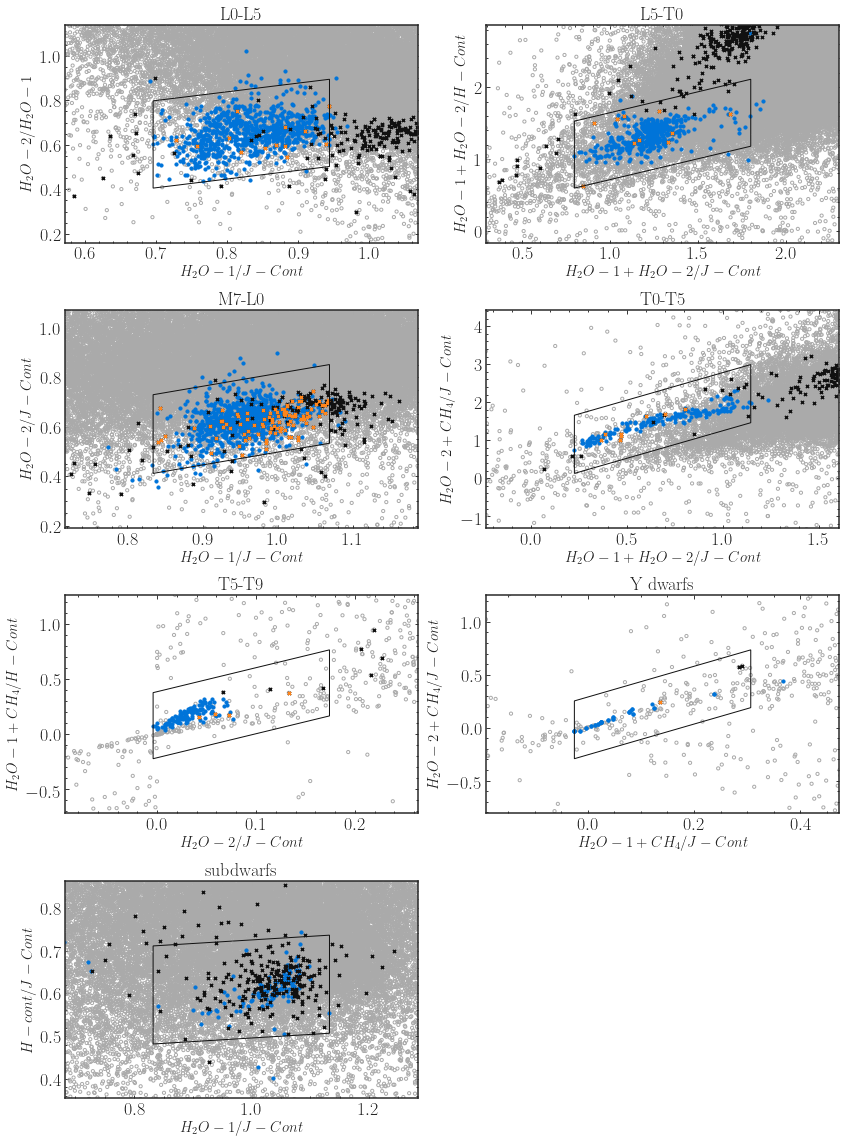

In [45]:
fig, ax=plt.subplots(nrows=4, ncols=2, figsize=(12, 16))

bxs=[]
for idx, k in enumerate(to_use.keys()):
    b=plot_index_box( k, to_use[k], np.concatenate(ax)[idx])
    bxs.append(b)
plt.tight_layout()
fig.delaxes(np.concatenate(ax)[-1])
plt.savefig(wisps.OUTPUT_FIGURES+'/index_index_plots.jpeg', bbox_inches='tight')

In [46]:
to_use

{'H_2O-1/J-Cont H_2O-2/H_2O-1': 'L0-L5',
 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont': 'L5-T0',
 'H_2O-1/J-Cont H_2O-2/J-Cont': 'M7-L0',
 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont': 'T0-T5',
 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont': 'T5-T9',
 'H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont': 'Y dwarfs',
 'H_2O-1/J-Cont H-cont/J-Cont': 'subdwarfs'}

In [47]:
common=dt[dt.grism_id.isin(cands.grism_id)]

In [48]:
cands.columns

Index(['grism_id', 'spectra', 'spt', 'distance', 'RA', 'DEC', 'snr1',
       'H_2O-1/J-Cont', 'H_2O-1/J-Cont_er', 'H_2O-2/H_2O-1',
       'H_2O-2/H_2O-1_er', 'H-cont/H_2O-1', 'H-cont/H_2O-1_er', 'CH_4/H_2O-1',
       'CH_4/H_2O-1_er', 'H_2O-2/J-Cont', 'H_2O-2/J-Cont_er', 'H-cont/J-Cont',
       'H-cont/J-Cont_er', 'CH_4/J-Cont', 'CH_4/J-Cont_er', 'H-cont/H_2O-2',
       'H-cont/H_2O-2_er', 'CH_4/H_2O-2', 'CH_4/H_2O-2_er', 'CH_4/H-Cont',
       'CH_4/H-Cont_er', 'H_2O-1+H_2O-2/J-Cont', 'H_2O-1+H_2O-2/J-Cont_er',
       'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+H_2O-2/H-Cont_er', 'H_2O-1+CH_4/J-Cont',
       'H_2O-1+CH_4/J-Cont_er', 'H_2O-2+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont_er',
       'H_2O-1+CH_4/H-Cont', 'H_2O-1+CH_4/H-Cont_er', 'H_2O-2+CH_4/H-Cont',
       'H_2O-2+CH_4/H-Cont_er'],
      dtype='object')

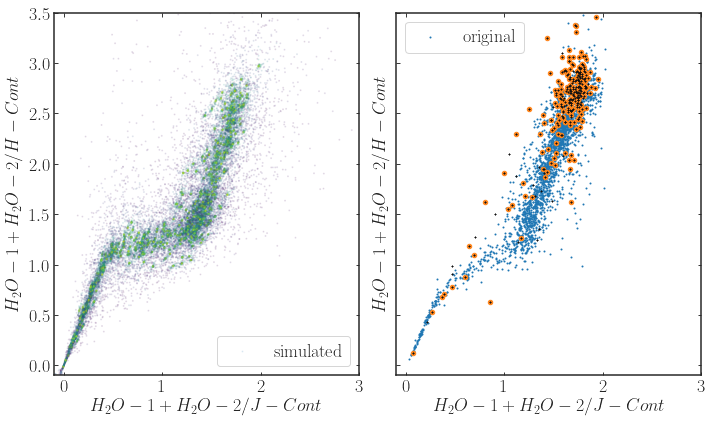

In [49]:
fig, ax=plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 6))

ax[0].scatter(simulated_data['H_2O-1+H_2O-2/J-Cont'],simulated_data['H_2O-1+H_2O-2/H-Cont'], 
            c=simulated_data.snr1.apply(np.log10), marker='o', alpha=0.1,label='simulated', cmap='viridis', s=1.)

ax[1].scatter(spex['H_2O-1+H_2O-2/J-Cont'],  spex['H_2O-1+H_2O-2/H-Cont'], label='original ', s=1.) 

ax[1].scatter(common['H_2O-1+H_2O-2/J-Cont'],  common['H_2O-1+H_2O-2/H-Cont'], facecolors='#FF851B',marker='o', s=20.) 
ax[1].scatter(cands['H_2O-1+H_2O-2/J-Cont'],  cands['H_2O-1+H_2O-2/H-Cont'], facecolors='#111111',marker='x', s=1.) 

plt.tight_layout()

ax[0].set_xlim([-0.1, 3.])
ax[0].set_ylim([-0.1, 3.5])



for a in ax:
    a.legend(fontsize=18)
    a.set_xlabel(r'$'+str('H_2O-1+H_2O-2/J-Cont'.split(' ')[0])+'$', fontsize=18)
    a.set_ylabel(r'$'+str('H_2O-1+H_2O-2/H-Cont'.split(' ')[0])+'$', fontsize=18)
    
    
plt.tight_layout()

In [50]:
bx_dict={}
for b in bxs:
    bx_dict.update(b)

In [51]:
#invert to use
inv_to_use = {v: k for k, v in to_use.items()}

In [52]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont H_2O-2/J-Cont',
 'T0-T5': 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [53]:
dt.shape

(70337, 57)

In [54]:
from tqdm import tqdm

In [55]:
ncandidates=[]
for spt_range in bx_dict.keys():
    idx_name=inv_to_use[spt_range]
    idx=crts[idx_name]
    s, bools=(bx_dict[spt_range])._select(np.array([dt[idx.xkey].values, dt[idx.ykey].values]))
    ncandidates.append(dt[bools])

In [56]:
candsss=(pd.concat(ncandidates).drop_duplicates(subset='grism_id'))

In [57]:
cands_dff.grism_id=cands_dff.grism_id.apply(lambda x: x.lower())

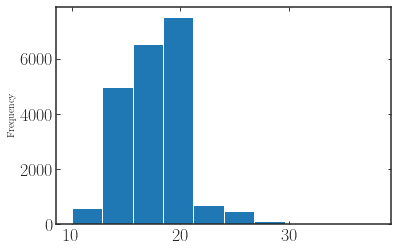

In [58]:
candsss.spt.plot(kind='hist')

In [59]:
len(candsss), len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>16)])

(20940, 170)

In [60]:
candsss.grism_id.values

array(['par321-00664', 'par356-00280', 'par251-00113', ...,
       'goodsn-13-g141_20032', 'goodsn-13-g141_17541',
       'goodsn-13-g141_20092'], dtype=object)

In [61]:
len(candsss[candsss.grism_id.isin(cands_dff.grism_id) & (candsss.spt.apply(wisps.make_spt_number)>=17)])

170

In [62]:
candsss.to_pickle(wisps.OUTPUT_FILES+'/selected_by_indices.pkl')

In [63]:
def round_tuple(tpl, n=2):
    return round(tpl[0], n), round(tpl[1],n)

In [64]:
inv_to_use

{'L0-L5': 'H_2O-1/J-Cont H_2O-2/H_2O-1',
 'L5-T0': 'H_2O-1+H_2O-2/J-Cont H_2O-1+H_2O-2/H-Cont',
 'M7-L0': 'H_2O-1/J-Cont H_2O-2/J-Cont',
 'T0-T5': 'H_2O-1+H_2O-2/J-Cont H_2O-2+CH_4/J-Cont',
 'T5-T9': 'H_2O-2/J-Cont H_2O-1+CH_4/H-Cont',
 'Y dwarfs': 'H_2O-1+CH_4/J-Cont H_2O-2+CH_4/J-Cont',
 'subdwarfs': 'H_2O-1/J-Cont H-cont/J-Cont'}

In [65]:
good_indices=[crts[x] for x in inv_to_use.values()]

In [66]:
for sindex, k in zip(good_indices, to_use.keys()):
   
    spt_range=to_use[k]
    bs=sindex.shapes
    bs=[x for x in bs if x.shape_name==spt_range]

    bx=bs[0]
    
    print (" {} & {} &  {} & {} & {} & {} & {} & {} & {}  & {} \\\ ".format(spt_range,sindex.xkey, sindex.ykey, 
                                                                           round_tuple(bx.vertices[0]), round_tuple(bx.vertices[1])
                                                                          , round_tuple(bx.vertices[2]), round_tuple(bx.vertices[3]),
                                                                          round(sindex.completeness[spt_range], 2), 
                                                                            round(sindex.contamination[spt_range], 3), 
                                                                           round(fp[spt_range], 2)))
    

 L0-L5 & H_2O-1/J-Cont &  H_2O-2/H_2O-1 & (0.7, 0.8) & (0.94, 0.89) & (0.94, 0.5) & (0.7, 0.41) & 0.98 & 0.044  & 0.99 \\ 
 L5-T0 & H_2O-1+H_2O-2/J-Cont &  H_2O-1+H_2O-2/H-Cont & (0.8, 1.53) & (1.8, 2.11) & (1.8, 1.18) & (0.8, 0.6) & 0.98 & 0.13  & 1.0 \\ 
 M7-L0 & H_2O-1/J-Cont &  H_2O-2/J-Cont & (0.83, 0.73) & (1.07, 0.85) & (1.07, 0.53) & (0.83, 0.41) & 0.97 & 0.081  & 0.97 \\ 
 T0-T5 & H_2O-1+H_2O-2/J-Cont &  H_2O-2+CH_4/J-Cont & (0.23, 1.66) & (1.15, 2.99) & (1.15, 1.46) & (0.23, 0.12) & 0.98 & 0.018  & 0.98 \\ 
 T5-T9 & H_2O-2/J-Cont &  H_2O-1+CH_4/H-Cont & (-0.0, 0.38) & (0.17, 0.77) & (0.17, 0.17) & (-0.0, -0.22) & 0.98 & 0.003  & 0.96 \\ 
 Y dwarfs & H_2O-1+CH_4/J-Cont &  H_2O-2+CH_4/J-Cont & (-0.02, 0.25) & (0.31, 0.73) & (0.31, 0.19) & (-0.02, -0.29) & 0.91 & 0.002  & 0.98 \\ 
 subdwarfs & H_2O-1/J-Cont &  H-cont/J-Cont & (0.83, 0.71) & (1.13, 0.74) & (1.13, 0.51) & (0.83, 0.48) & 0.94 & 0.118  & 1.0 \\ 
